## Available Features
Temperature (AT) | Ambient Pressure(AP) | Relative Humidity (RH) | Exhaust Vaccum (V)
## Target 
Net hourly electrical energy output (PE)

In [10]:
import pandas as pd

df = pd.read_csv(
    "CCPP_data.csv",
)
df.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


### Exploratory Data Analysis
The data seems clean, there is no missing data, and all features are numeric. It has around 9.5K observations, with 4 features. Let's check how our target variable is distributed.

Text(0.5, 1.0, 'Net hourly electrical energy output distribution')

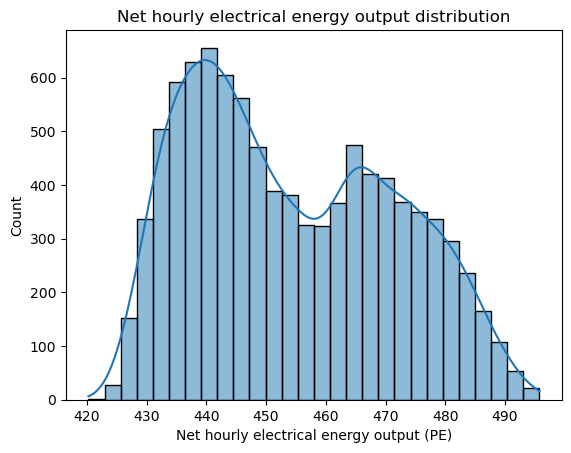

In [17]:
import seaborn as sns

hist_plot = sns.histplot(data=df, x="PE", kde=True)
hist_plot.set_xlabel("Net hourly electrical energy output (PE)")
hist_plot.set_title("Net hourly electrical energy output distribution")

We can see that our target variable is a bimodal lognormal distribution. Let's analyze our features now.

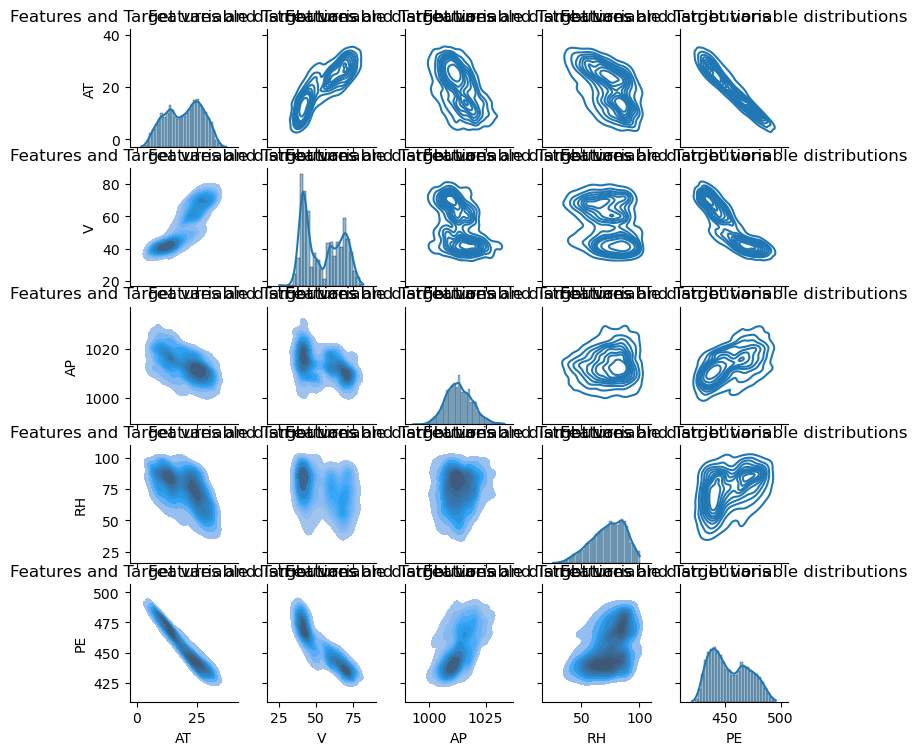

In [18]:
g = sns.PairGrid(df, height=1.5)
g.set(title="Features and Target variable distributions")
g.map_upper(sns.kdeplot, fill=False)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

A few insights:
- AT and V have bimodal distributions
- AP has a normal distribution
- RH has a log normal distribution

We can see some correlation between some of the features and our target values, let's analyze its correlation

<Axes: >

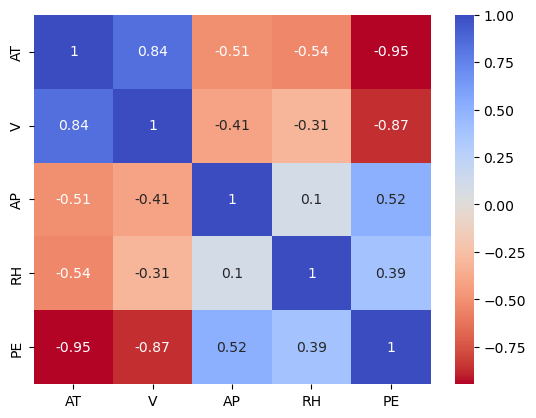

In [5]:
sns.heatmap(df.corr(), cmap="coolwarm_r", annot=True)

We can confirm that
- AT and V show a strong inverse correlationship with PE
- AP and Rh show a positive correlationship with PE

Considering the features and the target variable, a linear regression model is appropiate. Considering that we only have a couple of features, regularization isn't required.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import sklearn.ensemble as em
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

X = df.loc[:, df.columns != "PE"]
y = df["PE"]


# First split: Train (60%) and Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Second split: Validation (50% of Temp = 20% of original data) and Test (50% of Temp = 20% of original data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Sets: Training set 60% ({len(X_train)}) | Validation set 20% ({len(X_val)}) | Test set 20% ({len(X_test)})\n")

# Define the models
models = {
    "Linear Regression": lm.LinearRegression(),
    "Ridge Regression": lm.Ridge(),
    "Lasso Regression": lm.Lasso(),
    "Gamma Regression": lm.GammaRegressor(),
    "Random Forest Regressor": em.RandomForestRegressor(),
    "Gradient Boosting Regressor": em.GradientBoostingRegressor(),
}

# Loop through models and evaluate performance
for model_name, model in models.items():
    # Fit the model on training data
    model.fit(X_train, y_train)
    # Predict on validation data
    y_val_pred = model.predict(X_val)
    # Evaluate on validation set
    print(f"Model: {model_name} (Validation Set)")
    print(f"Coefficients: {model.coef_ if hasattr(model, 'coef_') else 'N/A'} | Intercept: {model.intercept_ if hasattr(model, 'intercept_') else 'N/A'}")
    print("Root Mean Squared Error (RMSE) on validation: %.4f" % root_mean_squared_error(y_val, y_val_pred))
    print("Coefficient of Determination (R²) on validation: %.4f\n" % r2_score(y_val, y_val_pred))

Sets: Training set 60% (5740) | Validation set 20% (1914) | Test set 20% (1914)

Model: Linear Regression (Validation Set)
Coefficients: [-1.99109819 -0.23175144  0.05030852 -0.1621682 ] | Intercept: 466.9907795675342
Root Mean Squared Error (RMSE) on validation: 4.4597
Coefficient of Determination (R²) on validation: 0.9337

Model: Ridge Regression (Validation Set)
Coefficients: [-1.99106245 -0.23176495  0.05031738 -0.1621622 ] | Intercept: 466.9813981031613
Root Mean Squared Error (RMSE) on validation: 4.4597
Coefficient of Determination (R²) on validation: 0.9337

Model: Lasso Regression (Validation Set)
Coefficients: [-1.93533273 -0.24999243  0.0368983  -0.14633001] | Intercept: 479.3113850744253
Root Mean Squared Error (RMSE) on validation: 4.4679
Coefficient of Determination (R²) on validation: 0.9335

Model: Gamma Regression (Validation Set)
Coefficients: [-0.00396053 -0.00068272  0.00013384 -0.00029025] | Intercept: 6.118818955487816
Root Mean Squared Error (RMSE) on validation

The tested models have barely the same results, so due simplicity we'll pick the standard Linear Regression as the best model.

Coefficients: 
 [-1.99109819 -0.23175144  0.05030852 -0.1621682 ]
[-1.99109819 -0.23175144  0.05030852 -0.1621682 ] 466.9907795675342
Final evaluation on Test Set:
Root Mean Squared Error (RMSE) on test: 4.6279
Coefficient of Determination (R²) on test: 0.9253


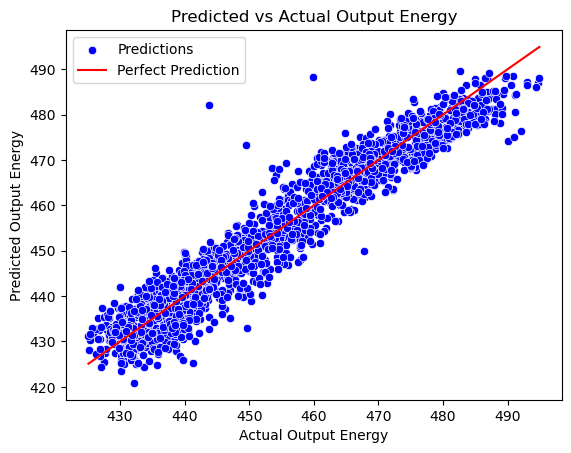

In [9]:
best_model = lm.LinearRegression()
best_model.fit(X_train, y_train)  # Re-train the chosen model on the full training data
# The coefficients
print("Coefficients: \n", best_model.coef_)
print(best_model.coef_, best_model.intercept_)

y_pred = best_model.predict(X_test)
print("Final evaluation on Test Set:")
print("Root Mean Squared Error (RMSE) on test: %.4f" % root_mean_squared_error(y_test, y_pred))
print("Coefficient of Determination (R²) on test: %.4f" % r2_score(y_test, y_pred))

sns.scatterplot(x=y_test, y=y_pred, color="blue", label="Predictions")
sns.lineplot(x=y_test, y=y_test, color="red", label="Perfect Prediction")
plt.xlabel("Actual Output Energy")
plt.ylabel("Predicted Output Energy")
plt.title("Predicted vs Actual Output Energy")
plt.legend()
plt.show()